# Spline transformations for images

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

## Minimization problem

Recall that for landmark matching, we wrote an energy cost function 

\begin{align*}
E = \frac{1}{2}\int v^T(x) A v(x)dx +  \frac{1}{2\sigma^2} \sum_{i = 1}^N |X_i + v(X_i) - Y_i|^2
\end{align*}

We will need to make a couple changes to work with images.  We write $\varphi^{-1} = x - v(x)$ and use integrated square error for an image matching cost.  We minimize the energy cost function

\begin{align*}
E = \frac{1}{2}\int v^T(x) A v(x)dx + \frac{1}{2\sigma^2}\int  (I(x-v(x)) - J(x))^2dx
\end{align*}

As before, we always use a perturbatoin $v \mapsto v + \epsilon \delta v$, and take the derivative with respect to $\epsilon$ in order to compute the directional derivative in the direction $\delta v$.
\begin{align*}
&\frac{d}{d\epsilon}\frac{1}{2}\int (v + \epsilon \delta v)^T(x) A (v + \epsilon \delta v)(x)dx +  \frac{1}{2\sigma^2}\int (I(x-v(x) - \epsilon \delta v) - J)^2dx \bigg|_{\epsilon = 0}\\
&= \int Av^T(x) \delta v(x)dx + \frac{1}{\sigma^2}\int (I(x - v(x)) - J(x))\frac{d}{d\epsilon} I(x - v(x) - \epsilon \delta v(x))\bigg|_{\epsilon = 0}dx\\
&= \int Av^T(x) \delta v(x)dx -\frac{1}{\sigma^2}\int (I(x - v(x)) - J(x)) DI(x - v(x))\delta v(x)dx\\
\end{align*}
If this is stationary for all perturbations, we require 
\begin{align*}
d E &= Av(x) - \frac{1}{\sigma^2}(I(x - v(x)) - J(x))\nabla I(x - v(x)) = 0
\end{align*}
We will use this differential to form a gradient descent algorithm.  Typically we act on this differential with the inverse of $A$, which is convolution with it's Green's kernel $K$, for reasons including numerical performance.  
We use the gradient vector
\begin{align*}
\nabla E = K* dE &= v(x) - \frac{1}{\sigma^2}K * (I(x - v(x)) - J(x))\nabla I(x - v(x))
\end{align*}

The gradient descent algorithm will be to initalize $v(x)$ (generally to 0), choose a small step size $\epsilon$, then update $v(x) \mapsto v(x) -\epsilon \nabla E = v(x)- \epsilon [v(x) - \frac{1}{\sigma^2}K * (I(x - v(x)) - J(x))\nabla I(x - v(x))]$

### Bonus: Differentials and gradients in function spaces

If you want to know more about the difference between "gradients" and "differentials", you can read this section.  Otherwise skip it.

We are working in a Hilbert space of smooth functions, with an inner product between $u$ and $v$ given by $\langle u, v \rangle = \int u^T(x) A v(x) dx$.  The difference between "differential", and "gradient vector" involves this inner product.  They are related by the definition
\begin{align}
\int dE^T(x) \delta v(x)dx = \langle \nabla E, \delta v \rangle
\end{align}
which implies $\nabla E = K*dE$.

We can plug it in and check
\begin{align}
 \langle \nabla E, \delta v \rangle &=  \langle K * d E, \delta v \rangle\\
&= \int (K*dE)^T(x)A \delta v(x) dx\\
&= \int (A (K*dE))^T(x) \delta v(x) dx\\
&= \int dE^T(x) \delta v(x) dx
\end{align}
Note we can move $A$ to the left side because it is symmetric (Hemitian).

Note that $dE$ is NOT a smooth function in our Hilbert space, but $\nabla E$ is.

## Energy operator in the discrete Fourier domain
Let's consider using $A = (id - a^2\Delta)^{2p}$ as we discussed in the spline landmark example.  

Working with it and its inverse by applying convolutions directly will be way too slow when working with images.  Instead, we can apply it by multiplication in the Fourier domain (a highpass filter).  And we we can apply its inverse by division in the Fourier domain (a lowpass filter).

For discrete images $I[i,j,k]$ with voxel spacing $\Delta x$ we define the discrete Laplacian as
\begin{align*}
[\Delta I][i,j,k] &= \frac{1}{dx[0]^2}(I[i+1,j,k] - 2I[i,j,k] + I[i-1,j,k]) + \ldots
\end{align*}
where ... refers to the same expression for the second and third indices (i.e. y and z variables).

Notice that on the right we just have shifts of the original image, which can be encoded in the frequency domain by modulation, i.e. multiplication by complex exponentials.
\begin{align*}
 \hat {[\Delta I]}[i,j,k] &= \frac{1}{dx[0]^2}(\hat I[i,j,k] \exp(2\pi \sqrt{-1}f_0[i]dx[0] ) - 2 I[i,j,k] + (\hat I[i,j,k] \exp(-2\pi \sqrt{-1}f_0[i]dx[0] )) + \ldots
\end{align*}
Combine the exponentials using Euler's equation to get cosines
\begin{align*}
&= \frac{1}{dx[0]^2}\hat I[i,j,k] (2\cos(2\pi f_0[i] dx[0])-2)+  \ldots
\end{align*}

So we can encode the whole operator in the fourier domain by
\begin{align*}
\hat A[i,j,k] = \left( 1 - 2a^2 \left( \frac{1}{dx[0]^2} (\cos(2\pi f_0[i] dx[0])-1)  \right) + \ldots \right)^{2p}
\end{align*}

Now $\hat K$ is just one over this.
\begin{align*}
\hat K[i,j,k] = \left( 1 - 2a^2 \left( \frac{1}{dx[0]^2} (\cos(2\pi f_0[i] dx[0])-1)  \right) + \ldots\right)^{-2p}
\end{align*}

In [2]:
# load a pair of images
fname = os.path.join('mouse_images','PMD2052_orig_target_STS_clean.img')
imgI = nib.load(fname)
nx = imgI.header['dim'][1:4]
dx = imgI.header['pixdim'][1:4]

fname = os.path.join('mouse_images','PMD3097_orig_target_STS_clean.img')
imgJ = nib.load(fname)

<IPython.core.display.Javascript object>


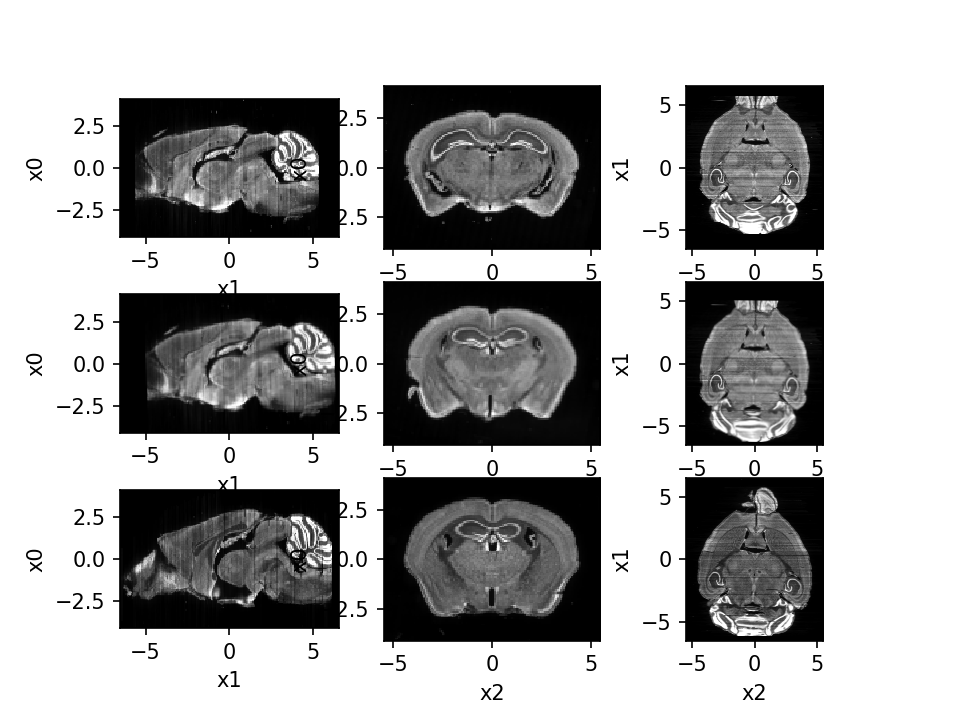

Top row: atlas, second row: affine transformed atlas, third row: target.


In [3]:
# affine transform the first to match the second
# load affine from last tutorial and apply it as in last tutorial
A = np.zeros((4,4))
with open('affine.txt','rt') as f:
    for i in range(4):
        line = f.readline()
        A[i,:] = [float(a) for a in line.split()]

x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')
X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
interp_args = {
    'method':'linear',
    'bounds_error':False,
    'fill_value':0
    }
AI = spi.interpn([x0,x1,x2],imgI.get_data()[:,:,:,0],np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
f,ax = plt.subplots(3,3)
ss.imshow_slices(x0,x1,x2,imgI.get_data()[:,:,:,0],ax[0])
ss.imshow_slices(x0,x1,x2,AI,ax[1])
ss.imshow_slices(x0,x1,x2,imgJ.get_data()[:,:,:,0],ax[2])

print('Top row: atlas, second row: affine transformed atlas, third row: target.')

<IPython.core.display.Javascript object>


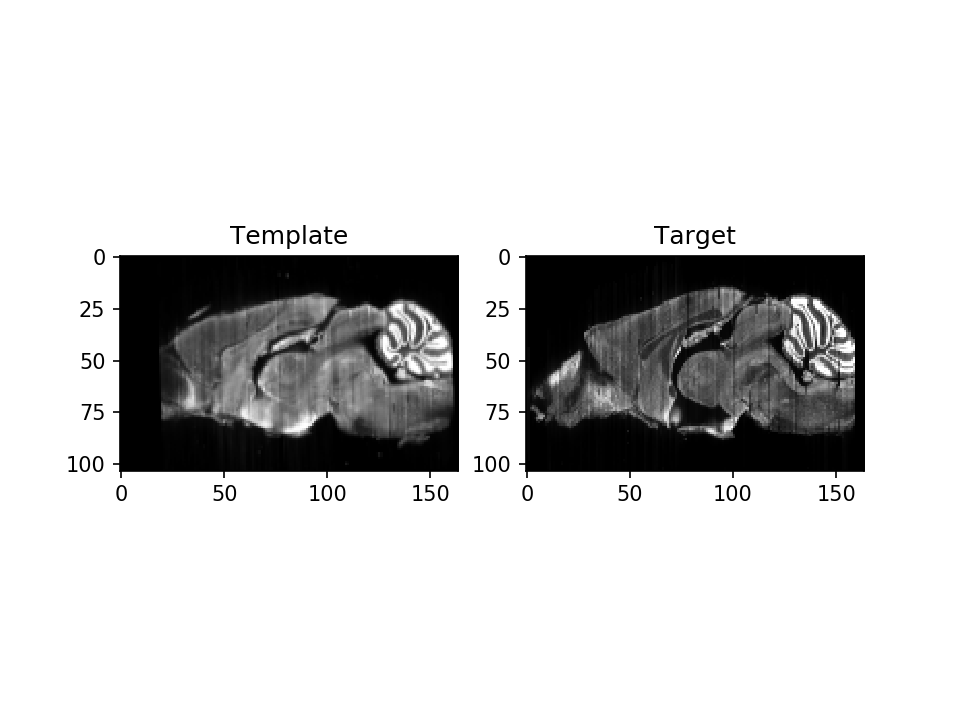

Text(0.5,1,'Target')

In [4]:
# start with a 2D example
# set up a domain
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
X0,X1 = np.meshgrid(x0,x1,indexing='ij')

I = AI[:,:,imgI.shape[2]//2]
J = imgJ.get_data()[:,:,imgJ.shape[2]//2,0] # note last axes is time, we'd like to remove it
# standardize the image intensities
I = (I - np.mean(I))/np.std(I)
J = (J - np.mean(J))/np.std(J)

f,ax = plt.subplots(1,2)
ax[0].imshow(I,cmap='gray')
ax[0].set_aspect('equal')
ax[0].set_title('Template')
ax[1].imshow(J,cmap='gray')
ax[1].set_aspect('equal')
ax[1].set_title('Target')

<IPython.core.display.Javascript object>


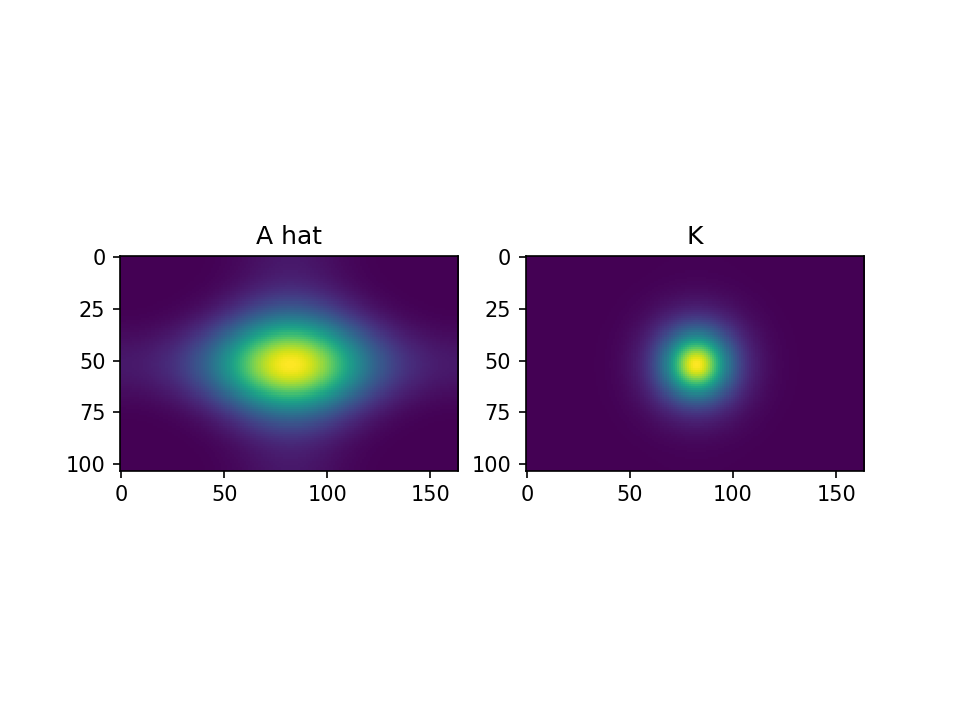

Notice how wide the scale of K is, we will want to choose parameters so that this scale is appropriate for our data


In [5]:
# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
F0,F1 = np.meshgrid(f0,f1,indexing='ij')
a = 10.0 # a scale in mm
# for mice
a = 5.0*dx[0]
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.fftshift(np.fft.ifft2(Khat,nx[:2]).real)

f,ax = plt.subplots(1,2)
ax[0].imshow(Ahat)
ax[0].set_title('A hat')
ax[1].imshow(K)
ax[1].set_title('K')

print('Notice how wide the scale of K is, we will want to choose parameters so that this scale is appropriate for our data')

<IPython.core.display.Javascript object>


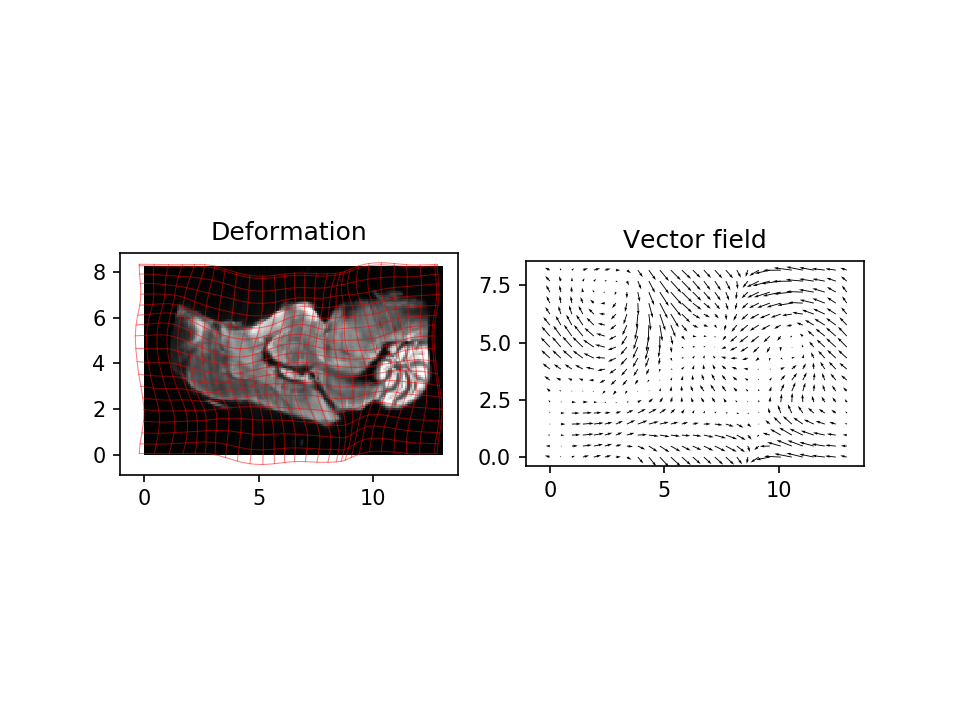

Text(0.5,1,'Vector field')

In [6]:
# generate an example smooth transformation of a specific magnitude mag
mag = 5.0e2
# for mouse
mag = 10.0
# some random numbers
v0 = np.random.randn(*nx[:2])*mag
v1 = np.random.randn(*nx[:2])*mag
# smooth them with our K
v0 = np.fft.ifft2(np.fft.fft2(v0,nx[:2])*Khat,nx[:2]).real
v1 = np.fft.ifft2(np.fft.fft2(v1,nx[:2])*Khat,nx[:2]).real
phiinv0 = X0-v0
phiinv1 = X1-v1
# deform the image using interpolation
interp_args = {'method':'linear','bounds_error':False,'fill_value':None}
phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)

f,ax = plt.subplots(1,2,sharex=True)
stride = 6
imshow_args = dict(cmap='gray',extent=[x1[0],x1[-1],x0[0],x0[-1]],origin='lower')
ax[0].imshow(phiI,**imshow_args)
ss.plot_grid(X1+v1,X0+v0,ax=ax[0],rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
ax[0].set_aspect('equal')
ax[0].set_title('Deformation')
ax[1].quiver(X1[::stride,::stride],X0[::stride,::stride],
             v1[::stride,::stride],v0[::stride,::stride])
ax[1].set_aspect('equal')
ax[1].set_title('Vector field')



<IPython.core.display.Javascript object>


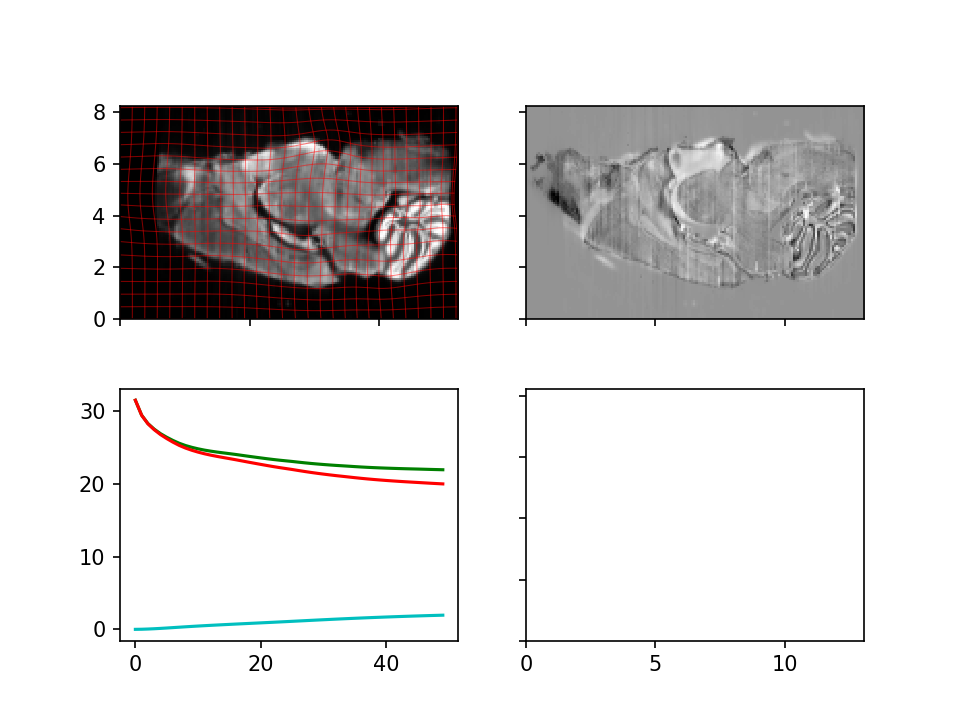

In [7]:
# now run spline matching optimization
# for display, create plots with shared axis
f,ax = plt.subplots(2,2,sharex=True,sharey=True)
# for plotting energy, no shared axis
f.delaxes(ax[1][0])
ax[1][0] = f.add_subplot(2,2,3)


# parameters
sigma = 2e0
niter = 50
epsilon = 2.0e-2
# for mouse
sigma = 1.0e0
epsilon = 2.0e-2


# initialize
v0 = np.zeros(nx[:2])
v1 = np.zeros(nx[:2])
I_0,I_1 = np.gradient(I,dx[0],dx[1])
EMAll = []
ERAll = []
EAll = []
for it in range(niter):
    # compute the deformed image
    phiinv0 = X0-v0
    phiinv1 = X1-v1
    phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    ax[0,0].cla()
    ax[0,0].imshow(phiI,**imshow_args)
    ss.plot_grid(X1+v1,X0+v0,ax=ax[0,0],color='r',alpha=0.5,linewidth=0.5,rstride=stride,cstride=stride)
    
    # error
    err = phiI - J
    ax[0,1].cla()
    ax[0,1].imshow(err,**imshow_args)
    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]
    EMAll.append(EM)
    
    Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
    Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
    ER = np.sum(v0*Av0 + v1*Av1)*0.5*dx[0]*dx[1]
    ERAll.append(ER)
    
    E = ER+EM
    EAll.append(E)
    ax[1,0].cla()
    ax[1][0].plot(EAll,'g')
    ax[1][0].plot(EMAll,'r')
    ax[1][0].plot(ERAll,'c')
    
    # deform gradient of I
    phiI_0 = spi.interpn([x0,x1],I_0,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    phiI_1 = spi.interpn([x0,x1],I_1,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    
    # start building the cost function gradient
    grad0 = -err*phiI_0/sigma**2
    grad1 = -err*phiI_1/sigma**2
    
    # smooth it
    grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
    grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real
    
    # add the regularization term
    grad0 += v0
    grad1 += v1
    
    # update
    v0 -= epsilon*grad0
    v1 -= epsilon*grad1
    
    f.canvas.draw()
    #plt.show()

## Now in 3D
There's really no significant difference in our 3D implementation

In [8]:
# load images
#I = imgI.get_data()[:,:,:,0]
I = AI
J = imgJ.get_data()[:,:,:,0]
# standardize the image intensities
I = (I - np.mean(I))/np.std(I)
J = (J - np.mean(J))/np.std(J)


down = 3
I = ss.downsample_image(I,down)
nx = I.shape
dx = imgI.header['pixdim'][1:4]*down
J = ss.downsample_image(J,down)
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
# center the axes at 0
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')

<IPython.core.display.Javascript object>


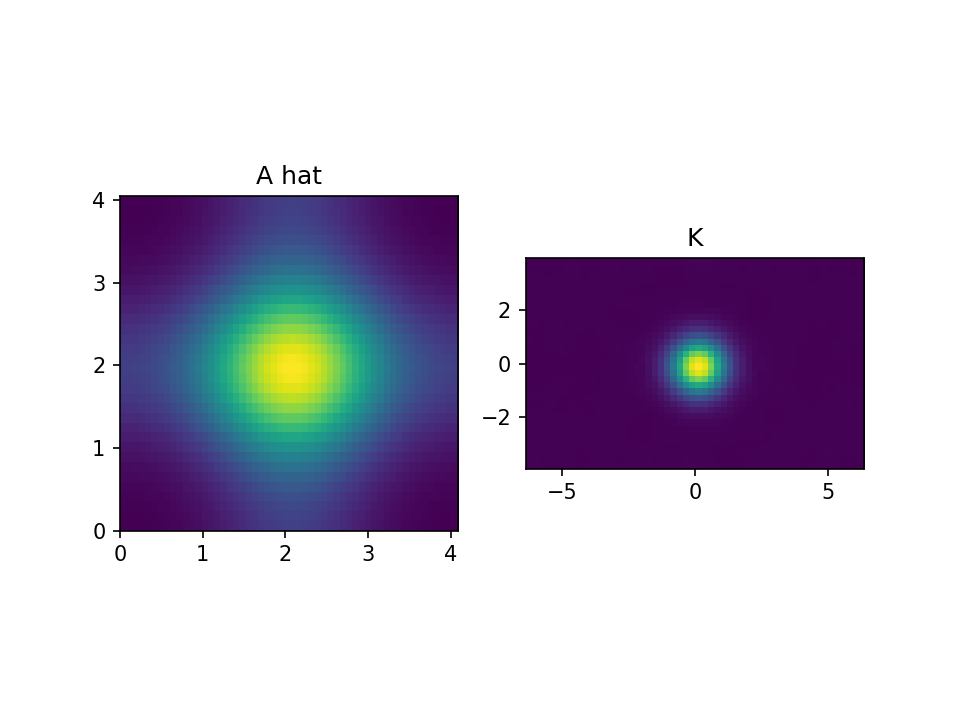

Notice the spatial scale of K and decide if it is appropriate for your data


In [9]:
# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
f2 = np.arange(nx[2])/(dx[2]*nx[2])
F0,F1,F2 = np.meshgrid(f0,f1,f2,indexing='ij')
a = 0.5*dx[0] # a scale in mm
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 
                        + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2
                        + (np.cos(2.0*np.pi*dx[2]*F2) - 1.0)/dx[2]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.fftshift(np.fft.ifftn(Khat).real)
f,ax = plt.subplots(1,2)
ax[0].imshow(Ahat[:,:,0],extent=(f1[0],f1[-1],f0[0],f0[-1]))
ax[0].set_title('A hat')
ax[1].imshow(K[:,:,0],extent=(x1[0],x1[-1],x0[0],x0[-1]))
ax[1].set_title('K')
print('Notice the spatial scale of K and decide if it is appropriate for your data')

<IPython.core.display.Javascript object>


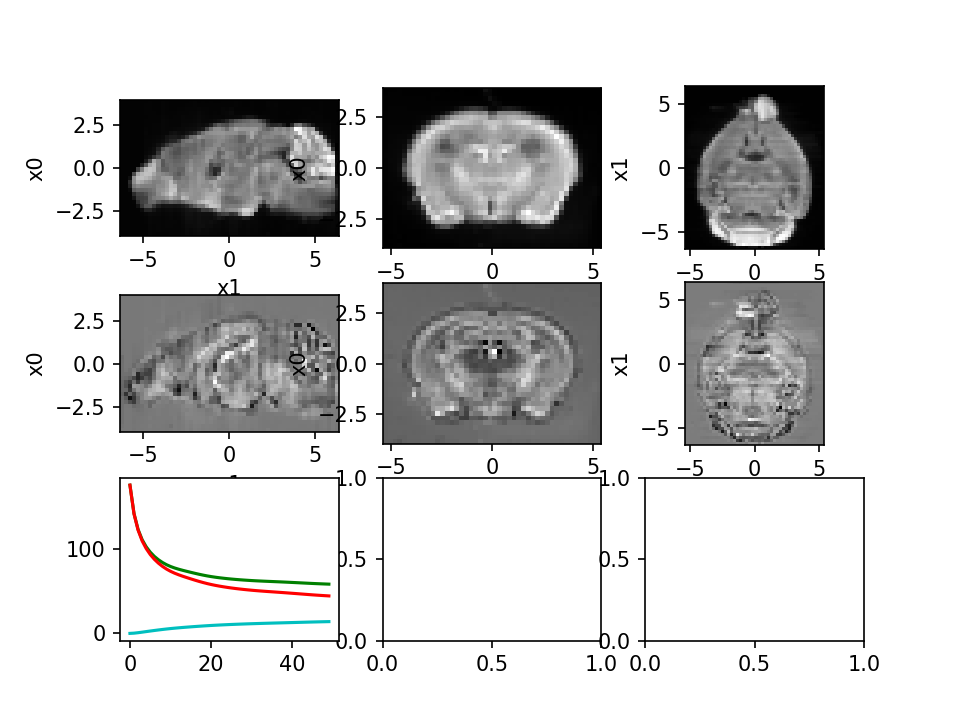

First row: deformed template, second row: difference between deformed template and target, third row: components of energy function


In [10]:
# now run matching
# for display, create plots with shared axis
f,ax = plt.subplots(3,3)
# for plotting energy, no shared axis
f.delaxes(ax[2][0])
ax[2][0] = f.add_subplot(3,3,7)
print('First row: deformed template, second row: \
difference between deformed template and target, \
third row: components of energy function')

# parameters
sigma = 2e0
niter = 50
epsilon = 2.0e-2
# for mouse
sigma = 1.0e0
epsilon = 2.0e-2

# initialize
v0 = np.zeros(nx)
v1 = np.zeros(nx)
v2 = np.zeros(nx)
I_0,I_1,I_2 = np.gradient(I,dx[0],dx[1],dx[2])
EMAll = []
ERAll = []
EAll = []
for it in range(niter):
    # compute the deformed image
    phiinv0 = X0-v0
    phiinv1 = X1-v1
    phiinv2 = X2-v2
    phiI = spi.interpn([x0,x1,x2],I,np.stack([phiinv0,phiinv1,phiinv2],axis=-1),**interp_args)
    [a.cla() for a in ax[0]]
    ss.imshow_slices(x0,x1,x2,phiI,ax[0])
    
    # error and cost functions
    err = phiI - J
    [a.cla() for a in ax[1]]
    ss.imshow_slices(x0,x1,x2,err,ax[1])
    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]*dx[2]
    EMAll.append(EM)
    
    Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
    Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
    Av2 = np.fft.ifftn(np.fft.fftn(v2)*Ahat).real
    ER = np.sum(v0*Av0 + v1*Av1 + v2*Av2)*0.5*dx[0]*dx[1]*dx[2]
    ERAll.append(ER)
    
    E = ER+EM
    EAll.append(E)
    ax[2][0].cla()
    ax[2][0].plot(EAll,'g')
    ax[2][0].plot(EMAll,'r')
    ax[2][0].plot(ERAll,'c')
    
    # deform the gradient of I
    phiI_0 = spi.interpn([x0,x1,x2],I_0,np.stack([phiinv0,phiinv1,phiinv2],axis=-1),**interp_args)
    phiI_1 = spi.interpn([x0,x1,x2],I_1,np.stack([phiinv0,phiinv1,phiinv2],axis=-1),**interp_args)
    phiI_2 = spi.interpn([x0,x1,x2],I_2,np.stack([phiinv0,phiinv1,phiinv2],axis=-1),**interp_args)
    
    # start building the cost function gradient
    grad0 = -err*phiI_0/sigma**2
    grad1 = -err*phiI_1/sigma**2
    grad2 = -err*phiI_2/sigma**2
    
    # smooth it
    grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
    grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real
    grad2 = np.fft.ifftn(np.fft.fftn(grad2)*Khat).real
    
    # add the regularization term
    grad0 += v0
    grad1 += v1
    grad2 += v2
    
    # update my vector field
    v0 -= epsilon*grad0
    v1 -= epsilon*grad1
    v2 -= epsilon*grad2
    
    f.canvas.draw()
